# Mod 4 Project - Time Series

* Student name: THOMAS J WHIPPLE
* Student pace: part time student
* Scheduled project review date/time: FRIDAY, MAY 15, 2020, 10:00am
* Instructor name: ABHINEET KULKARNI
* Blog post URL:  https://medium.com/@mrtjwhipple/zillow-time-series-352ed141a4a


## Zillow Small Dataset Predictor

For this Flatiron Module 4 project, I will be forecasting real estate prices of various zip codes using data from the small Zillow dataset. I will be acting as a consultant for a fictional real-estate investment firm and need to build a time series model to justify my findings. The firm has asked me to determine:

> What are the top 5 best zip codes in the USA to invest?

# Import Necessary Libraries

In [1]:
# Below are the libraries I will use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

np.random.seed(123) 

# Load the Data

In [2]:
df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# EDA

## Filtering for Chosen Zipcodes 
Narrow down my 14,723 zipcodes...

In [4]:
# Change RegionName to Zipcode
df = df.rename(columns={'RegionName': 'Zipcode'})
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
df.SizeRank.describe()

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64

In [6]:
df.RegionID.describe()

count     14723.000000
mean      81075.010052
std       31934.118525
min       58196.000000
25%       67174.500000
50%       78007.000000
75%       90920.500000
max      753844.000000
Name: RegionID, dtype: float64

In [7]:
# Drop unnecessary columns
df = df.drop(['RegionID', 'SizeRank'], axis = 1)
df.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [8]:
df.CountyName.describe()

count           14723
unique           1212
top       Los Angeles
freq              264
Name: CountyName, dtype: object

In [9]:
df.CountyName.unique()

array(['Cook', 'Collin', 'Harris', ..., 'Sunflower', 'Jewell', 'Licking'],
      dtype=object)

In [10]:
df.Metro.describe()

count        13680
unique         701
top       New York
freq           779
Name: Metro, dtype: object

In [11]:
df.State.describe()

count     14723
unique       51
top          CA
freq       1224
Name: State, dtype: object

In [12]:
df[df.State == 'VT'].count()

Zipcode       16
City          16
State         16
Metro         16
CountyName    16
              ..
2017-12       16
2018-01       16
2018-02       16
2018-03       16
2018-04       16
Length: 270, dtype: int64

In [13]:
df[df.State == 'VT']

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6146,5641,Barre,VT,Barre,Washington,86600.0,86100.0,85700.0,85300.0,84900.0,...,168700,170100,172100,173200,172700,171400,169500,167900,166900,166200
6188,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,208700,209600,209200,208200,207400,207200,207900,208900,210300,211500
7185,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,247400,249200,251900,254000,254700,253100,249400,246400,244900,243500
9222,5488,Swanton,VT,Burlington,Franklin,104200.0,103700.0,103200.0,102700.0,102200.0,...,193500,193600,192800,192200,192200,192600,193000,193700,194500,195300
10300,5676,Waterbury,VT,Barre,Washington,85100.0,84900.0,84800.0,84600.0,84400.0,...,253700,255700,259000,261900,262900,261300,258100,255400,253200,251300
10687,5450,Enosburg Falls,VT,Burlington,Franklin,37500.0,37400.0,37400.0,37400.0,37400.0,...,166000,166000,165500,165400,165700,166200,167000,167300,167200,167300
10897,5663,Northfield,VT,Barre,Washington,91900.0,91600.0,91300.0,90900.0,90700.0,...,172900,173600,175400,177400,178200,177400,175700,174100,173300,172900
10991,5454,Fairfax,VT,Burlington,Franklin,132900.0,132000.0,131200.0,130300.0,129300.0,...,255800,256900,256500,256100,256400,257200,258100,259300,260600,261800
11464,5673,Fayston,VT,Barre,Washington,77500.0,77200.0,76800.0,76400.0,76100.0,...,318600,320400,324700,328400,330700,330000,325700,321200,319700,318800
12383,5476,Richford,VT,Burlington,Franklin,52400.0,52000.0,51600.0,51200.0,50800.0,...,106000,105800,104300,103300,102600,101800,102300,104400,106100,107200


In [14]:
# My Vermont zip code is not in the set.
df[df.Zipcode == 5156].count()

Zipcode       0
City          0
State         0
Metro         0
CountyName    0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 270, dtype: int64

### New England zip codes

In [15]:
# New England zipcodes
NE_zips = df.loc[df['Zipcode'] < 9999]
NE_zips.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
57,7030,Hoboken,NJ,New York,Hudson,301600.0,302700.0,303800.0,304800.0,305800.0,...,1789100,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300
73,8701,Lakewood,NJ,New York,Ocean,153800.0,153400.0,153000.0,152500.0,152200.0,...,400500,403900,408400,411000,412600,414000,415700,415600,413400,410700
88,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,416900,417800,421100,425100,428600,431900,435700,440500,445800,449100
112,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,188900,190000,191200,191800,192900,193600,194100,194900,195700,195700
149,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,439100,442400,446700,451400,454700,457700,461900,466000,469300,471100


In [16]:
NE_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1403 entries, 57 to 14719
Columns: 270 entries, Zipcode to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 2.9+ MB


In [17]:
# There should be six New England states!
NE_zips.State.unique()

array(['NJ', 'MA', 'CT', 'ME', 'RI', 'NH', 'VT'], dtype=object)

In [18]:
# Whooops, New Jersey is not a part of New England!
NE_zips.drop(NE_zips[NE_zips['State'] == 'NJ'].index, inplace=True) 

/Users/whipxach/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
NE_zips.State.unique()

array(['MA', 'CT', 'ME', 'RI', 'NH', 'VT'], dtype=object)

In [20]:
NE_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 88 to 14719
Columns: 270 entries, Zipcode to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 1.9+ MB


In [21]:
NE_zips.Zipcode.max()

6897

In [22]:
# I viewed this map of the New England states.
from IPython.display import Image
from IPython.core.display import HTML 
basin_url = ("https://newengland.com/wp-content/uploads/new-england-states-map.jpg")
Image(url=basin_url, width=500, height=400)

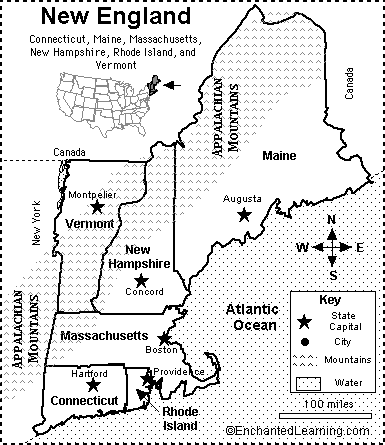

In [23]:
# I viewed this map of the New England states.
from IPython.display import Image 
Image("../time-series/new_england.gif")

### Population and zipcodes

In [24]:
# Population by state database 
# From "The US Decennial Census of Population and Housing"
population = pd.read_csv('population_by_zip_2010.csv')
population.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,50,30.0,34.0,female,61747,8600000US61747
1,5,85.0,NaN,male,64120,8600000US64120
2,1389,30.0,34.0,male,95117,8600000US95117
3,231,60.0,61.0,female,74074,8600000US74074
4,56,0.0,4.0,female,58042,8600000US58042


In [25]:
# Looks pretty straight forward...
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622831 entries, 0 to 1622830
Data columns (total 6 columns):
population     1622831 non-null int64
minimum_age    1523474 non-null float64
maximum_age    1457236 non-null float64
gender         1589712 non-null object
zipcode        1622831 non-null int64
geo_id         1622831 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 74.3+ MB


In [26]:
# But when I check out my zip code this dataframe is really confusing
population[population.zipcode == 5156].head(10)

,population,minimum_age,maximum_age,gender,zipcode,geo_id
18952,9226,NaN,NaN,NaN,5156,8600000US05156
28666,129,67.0,69.0,female,5156,8600000US05156
60305,99,18.0,19.0,male,5156,8600000US05156
85810,136,75.0,79.0,female,5156,8600000US05156
95394,161,70.0,74.0,male,5156,8600000US05156
118648,270,10.0,14.0,female,5156,8600000US05156
152606,91,85.0,NaN,male,5156,8600000US05156
174155,392,45.0,49.0,male,5156,8600000US05156
443238,258,5.0,9.0,female,5156,8600000US05156
446662,41,20.0,20.0,male,5156,8600000US05156


In [27]:
# I need to sort out only the totals, which are integrated into the columns
totals = population[(population['minimum_age'].isnull()) & 
                    (population['maximum_age'].isnull()) & 
                    (population['gender'].isnull())]

In [28]:
# Looks like that worked
totals.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
36,27669,NaN,NaN,NaN,91324,8600000US91324
116,4449,NaN,NaN,NaN,72632,8600000US72632
127,473,NaN,NaN,NaN,72739,8600000US72739
135,1685,NaN,NaN,NaN,27305,8600000US27305
178,24425,NaN,NaN,NaN,1843,8600000US01843


In [29]:
# This looks more like the correct numbers!
totals[totals.zipcode == 5156]

,population,minimum_age,maximum_age,gender,zipcode,geo_id
18952,9226,NaN,NaN,NaN,5156,8600000US05156


In [30]:
# Simplify new dataframe to get rid of everything else
totals = totals[['population', 'zipcode']]
totals.head()

,population,zipcode
36,27669,91324
116,4449,72632
127,473,72739
135,1685,27305
178,24425,1843


In [31]:
# Reduce it down to just New England again
totals = totals.loc[(totals['zipcode'] < 6999) & (totals['zipcode'] > 999)]
totals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1832 entries, 178 to 1621371
Data columns (total 2 columns):
population    1832 non-null int64
zipcode       1832 non-null int64
dtypes: int64(2)
memory usage: 42.9 KB


In [32]:
# Looks like it's still going to be bigger than my original dataset
totals.describe()

,population,zipcode
count,1832.000000,1832.000000
mean,7884.877183,3958.088974
std,10428.089613,1682.834151
min,0.000000,1001.000000
25%,1061.500000,2563.750000
50%,3234.000000,4070.000000
75%,10556.500000,5350.500000
max,63406.000000,6907.000000


In [33]:
# Merge the lat and lon with my first NE dataframe
ne_pops = NE_zips.merge(totals, left_on='Zipcode', right_on='zipcode')
ne_pops.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population,zipcode
0,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,421100,425100,428600,431900,435700,440500,445800,449100,55055,2169
1,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,191200,191800,192900,193600,194100,194900,195700,195700,60448,6010
2,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,446700,451400,454700,457700,461900,466000,469300,471100,59503,2148
3,2155,Medford,MA,Boston,Middlesex,157100.0,157300.0,157500.0,157800.0,158100.0,...,576400,582800,588600,594700,602100,609000,613300,614800,57964,2155
4,2360,Plymouth,MA,Boston,Plymouth,125900.0,126200.0,126500.0,126700.0,126800.0,...,344900,347200,349000,351300,354400,356800,358300,358400,56271,2360


In [34]:
# Get rid of the second zipcode (not sure how to do this in 'merge')
ne_pops.drop('zipcode', axis=1, inplace=True)
ne_pops.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
0,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,417800,421100,425100,428600,431900,435700,440500,445800,449100,55055
1,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,190000,191200,191800,192900,193600,194100,194900,195700,195700,60448
2,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,442400,446700,451400,454700,457700,461900,466000,469300,471100,59503
3,2155,Medford,MA,Boston,Middlesex,157100.0,157300.0,157500.0,157800.0,158100.0,...,570100,576400,582800,588600,594700,602100,609000,613300,614800,57964
4,2360,Plymouth,MA,Boston,Plymouth,125900.0,126200.0,126500.0,126700.0,126800.0,...,341700,344900,347200,349000,351300,354400,356800,358300,358400,56271


In [35]:
# Still at 901 zipcodes in New England
ne_pops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 0 to 900
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 1.9+ MB


In [36]:
# Look at the demographics
ne_pops.population.describe()

count      901.000000
mean     12392.804661
std      11700.762013
min        143.000000
25%       3297.000000
50%       8088.000000
75%      17700.000000
max      61025.000000
Name: population, dtype: float64

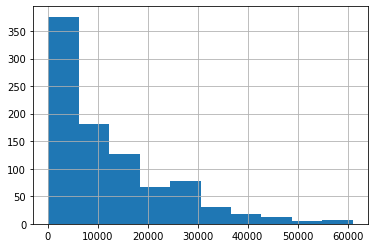

In [37]:
ne_pops.population.hist()

In [38]:
# Towns less than 3000 people
ne_rural = ne_pops.loc[(ne_pops['population'] < 3000)]
ne_rural.head()                       

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
427,2657,Provincetown,MA,Cape Cod,Barnstable,149800.0,151800.0,153700.0,155800.0,157900.0,...,834100,842000,854200,867800,874700,872000,890200,925300,946200,2942
575,2639,Dennis,MA,Cape Cod,Barnstable,100100.0,100000.0,100000.0,99900.0,99800.0,...,315400,316800,317700,318800,319200,318900,319900,322400,324000,2875
594,2667,Wellfleet,MA,Cape Cod,Barnstable,164500.0,163500.0,162500.0,161400.0,160400.0,...,545100,547700,547800,549800,551800,552400,555900,561200,563000,2580
646,5673,Fayston,VT,Barre,Washington,77500.0,77200.0,76800.0,76400.0,76100.0,...,320400,324700,328400,330700,330000,325700,321200,319700,318800,2574
659,3753,Grantham,NH,Claremont,Sullivan,146300.0,145300.0,144400.0,143500.0,142700.0,...,260100,261300,261900,262300,262900,263100,262800,262700,262600,2971


In [39]:
ne_rural.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 427 to 900
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 422.9+ KB


In [40]:
ne_rural.State.value_counts()

NH    86
MA    61
CT    20
ME    19
VT     7
RI     6
Name: State, dtype: int64

In [165]:
# Towns more than 50000 people
ne_towns = ne_pops.loc[(ne_pops['population'] > 47000)]
ne_towns.head()      

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
0,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,417800,421100,425100,428600,431900,435700,440500,445800,449100,55055
1,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,190000,191200,191800,192900,193600,194100,194900,195700,195700,60448
2,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,442400,446700,451400,454700,457700,461900,466000,469300,471100,59503
3,2155,Medford,MA,Boston,Middlesex,157100.0,157300.0,157500.0,157800.0,158100.0,...,570100,576400,582800,588600,594700,602100,609000,613300,614800,57964
4,2360,Plymouth,MA,Boston,Plymouth,125900.0,126200.0,126500.0,126700.0,126800.0,...,341700,344900,347200,349000,351300,354400,356800,358300,358400,56271


In [166]:
ne_towns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 58
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 31.9+ KB


In [197]:
ne_towns.State.value_counts()

MA    11
CT     4
Name: State, dtype: int64

In [515]:
# Villages around 12,000 people
ne_villages = ne_pops.loc[(ne_pops['population'] > 10000) & (ne_pops['population'] < 16000)]
ne_villages.head() 

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
198,2649,Mashpee,MA,Cape Cod,Barnstable,133000.0,132900.0,132700.0,132400.0,132100.0,...,401100,404500,407100,410900,414000,415100,417600,422400,425600,14006
203,3246,Laconia,NH,Laconia,Belknap,84800.0,84300.0,83900.0,83500.0,83200.0,...,179500,180700,182100,183800,185900,187800,189600,192000,194300,15963
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184
218,3842,Hampton,NH,Boston,Rockingham,135400.0,135600.0,135900.0,136300.0,136800.0,...,379500,382000,384700,387100,389100,390600,391800,394600,398100,15345
220,2601,Barnstable,MA,Cape Cod,Barnstable,95000.0,94800.0,94600.0,94400.0,94200.0,...,278100,280600,282700,285300,287700,289200,292900,299800,305300,14089


In [516]:
ne_villages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 198 to 475
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 272.0+ KB


In [517]:
ne_villages.State.value_counts()

MA    78
CT    19
NH    18
RI     7
ME     4
VT     2
Name: State, dtype: int64

In [518]:
# Thin out Mass
ne_villages.drop(ne_villages[(ne_villages.State == "MA") & 
                             (ne_villages.population > 14000)].index,
                 inplace=True)
ne_villages.State.value_counts()

MA    51
CT    19
NH    18
RI     7
ME     4
VT     2
Name: State, dtype: int64

In [519]:
# No Boston Suburbs!
ne_villages.drop(ne_villages[ne_villages.Metro == "Boston"].index, inplace=True)

In [520]:
# No Fall River!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Bristol"].index, inplace=True)

In [521]:
# No Cape Cod!
ne_villages.drop(ne_villages[ne_villages.Metro == "Cape Cod"].index, inplace=True)

In [522]:
# No Springfield!
ne_villages.drop(ne_villages[ne_villages.City == "Springfield"].index, inplace=True)

In [525]:
# No Worcester Suburbs!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Worcester"].index, inplace=True)

In [526]:
ne_villages.loc[(ne_villages['State'] == 'MA')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
364,1030,Agawam,MA,Springfield,Hampden,121700.0,121500.0,121200.0,121000.0,120800.0,...,238700,239500,239500,238500,237400,236700,236600,237900,239300,11669
365,1062,Northampton,MA,Springfield,Hampshire,127000.0,126200.0,125300.0,124400.0,123500.0,...,274600,276700,278800,280900,282800,284600,285200,282600,279500,11150
371,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,174600,175400,176500,178000,179400,181100,182500,183300,183800,10322


In [527]:
ne_villages.State.value_counts()

CT    19
NH    13
RI     6
ME     4
MA     3
VT     2
Name: State, dtype: int64

In [528]:
ne_villages.loc[(ne_villages['State'] == 'CT')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
263,6517,Hamden,CT,New Haven,New Haven,119900.0,119800.0,119600.0,119500.0,119500.0,...,224000,227200,229600,230900,231400,232100,231700,228600,225200,14853
292,6355,Groton,CT,New London,New London,136700.0,136900.0,137000.0,137100.0,137300.0,...,270900,269300,268200,268000,268800,270000,271800,273600,274200,12985
305,6416,Cromwell,CT,Hartford,Middlesex,145800.0,145400.0,145100.0,144700.0,144200.0,...,250500,253300,255800,258100,259900,261100,261000,259300,258000,14005
306,6357,Niantic,CT,New London,New London,123600.0,123800.0,123900.0,123900.0,123900.0,...,274400,276800,277800,277500,277300,278300,279500,279800,278800,12552
313,6461,Milford,CT,New Haven,New Haven,161400.0,161000.0,160700.0,160400.0,160200.0,...,308800,308900,308700,309200,310400,311700,313700,315700,316500,14552
326,6795,Watertown,CT,Torrington,Litchfield,149300.0,148900.0,148700.0,148500.0,148400.0,...,248800,249900,250800,252500,253600,253400,251100,248900,247800,14144
329,6706,Waterbury,CT,New Haven,New Haven,80800.0,80600.0,80400.0,80200.0,80000.0,...,102700,103600,105100,107200,108900,109800,109500,109000,108600,14324
334,6477,Orange,CT,New Haven,New Haven,205900.0,205400.0,204900.0,204400.0,204100.0,...,348200,348400,349400,350300,351500,352900,354500,355600,355600,13956
339,6076,Stafford Springs,CT,Hartford,Tolland,117200.0,116700.0,116100.0,115500.0,114900.0,...,196000,195300,193900,192000,190800,190600,190400,189700,188800,12659
342,6475,Old Saybrook,CT,Hartford,Middlesex,156500.0,155900.0,155300.0,154800.0,154300.0,...,355900,357100,357800,359100,360000,361500,362400,361300,359600,10242


In [529]:
# Thin out CT - Don't want to live in the capital!
ne_villages.drop(ne_villages[(ne_villages.Metro == "Hartford")].index, 
                 inplace=True)

In [530]:
# Who wants to live near 'Yale University'!
ne_villages.drop(ne_villages[ne_villages.Metro == "New Haven"].index, inplace=True)

In [531]:
# Too close to NYC!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Fairfield"].index, inplace=True)

In [532]:
# Too close to NYC!
ne_villages.drop(ne_villages[ne_villages.City == "Watertown"].index, inplace=True)

In [533]:
ne_villages.loc[(ne_villages['State'] == 'CT')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
292,6355,Groton,CT,New London,New London,136700.0,136900.0,137000.0,137100.0,137300.0,...,270900,269300,268200,268000,268800,270000,271800,273600,274200,12985
306,6357,Niantic,CT,New London,New London,123600.0,123800.0,123900.0,123900.0,123900.0,...,274400,276800,277800,277500,277300,278300,279500,279800,278800,12552
360,6098,Winsted,CT,Torrington,Litchfield,108700.0,108600.0,108500.0,108300.0,108100.0,...,160000,160700,161300,162600,163900,164800,164800,164300,164400,12426
403,6382,Montville,CT,New London,New London,112800.0,112800.0,112800.0,112800.0,112800.0,...,179300,180600,181600,182400,182400,182600,183300,183900,183700,11947


In [534]:
ne_villages.State.value_counts()

NH    13
RI     6
CT     4
ME     4
MA     3
VT     2
Name: State, dtype: int64

In [535]:
ne_villages.loc[(ne_villages['State'] == 'NH')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
203,3246,Laconia,NH,Laconia,Belknap,84800.0,84300.0,83900.0,83500.0,83200.0,...,179500,180700,182100,183800,185900,187800,189600,192000,194300,15963
273,3303,Concord,NH,Concord,Merrimack,87900.0,87900.0,87800.0,87700.0,87700.0,...,215300,217100,218200,219000,219800,220700,221100,221100,220900,15524
274,3055,Milford,NH,Manchester,Hillsborough,115300.0,115500.0,115800.0,116100.0,116400.0,...,257400,260400,262300,263700,264800,265300,266000,267100,268000,15086
289,3743,Claremont,NH,Claremont,Sullivan,68500.0,68400.0,68400.0,68400.0,68300.0,...,124400,124400,124600,124700,124700,124400,124100,123400,122700,14103
302,3064,Nashua,NH,Manchester,Hillsborough,110300.0,110000.0,109800.0,109600.0,109400.0,...,269400,272200,274500,275800,276600,277200,278400,280600,282300,14227
320,3106,Hooksett,NH,Concord,Merrimack,119000.0,118800.0,118700.0,118600.0,118500.0,...,280700,282700,284600,285700,287100,289000,291000,293400,294800,13374
341,3045,Goffstown,NH,Manchester,Hillsborough,110700.0,110000.0,109400.0,108800.0,108300.0,...,268200,270400,272300,273900,274500,275300,276500,277500,277700,13560
353,3076,Pelham,NH,Manchester,Hillsborough,143500.0,144000.0,144400.0,144700.0,144900.0,...,350900,352600,353400,354200,354800,354500,355100,357700,360000,12897
361,3275,Suncook,NH,Concord,Merrimack,93700.0,93300.0,93000.0,92700.0,92300.0,...,223900,226300,228400,230400,231900,232900,233600,234300,234800,11437
385,3570,Berlin,NH,Berlin,Coos,47600.0,47700.0,47900.0,48000.0,48100.0,...,70400,70800,71000,70800,70200,70000,69900,69100,67500,10051


In [536]:
# Who wants to live near Manchester!
ne_villages.drop(ne_villages[ne_villages.Metro == "Manchester"].index, inplace=True)

In [537]:
ne_villages.loc[(ne_villages['State'] == 'NH')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
203,3246,Laconia,NH,Laconia,Belknap,84800.0,84300.0,83900.0,83500.0,83200.0,...,179500,180700,182100,183800,185900,187800,189600,192000,194300,15963
273,3303,Concord,NH,Concord,Merrimack,87900.0,87900.0,87800.0,87700.0,87700.0,...,215300,217100,218200,219000,219800,220700,221100,221100,220900,15524
289,3743,Claremont,NH,Claremont,Sullivan,68500.0,68400.0,68400.0,68400.0,68300.0,...,124400,124400,124600,124700,124700,124400,124100,123400,122700,14103
320,3106,Hooksett,NH,Concord,Merrimack,119000.0,118800.0,118700.0,118600.0,118500.0,...,280700,282700,284600,285700,287100,289000,291000,293400,294800,13374
361,3275,Suncook,NH,Concord,Merrimack,93700.0,93300.0,93000.0,92700.0,92300.0,...,223900,226300,228400,230400,231900,232900,233600,234300,234800,11437
385,3570,Berlin,NH,Berlin,Coos,47600.0,47700.0,47900.0,48000.0,48100.0,...,70400,70800,71000,70800,70200,70000,69900,69100,67500,10051
475,3755,Hanover,NH,Claremont,Grafton,210000.0,209500.0,208900.0,208400.0,208000.0,...,636800,641200,647700,650600,650100,650700,653700,656400,655900,10538


In [538]:
# Who wants to live near Manchester!
ne_villages.drop(ne_villages[ne_villages.Metro == "Concord"].index, inplace=True)

In [539]:
ne_villages.State.value_counts()

RI    6
NH    4
CT    4
ME    4
MA    3
VT    2
Name: State, dtype: int64

In [540]:
# No Suburbs of Providence!
ne_villages.drop(ne_villages[(ne_villages.City == "Cranston") | 
                             (ne_villages.City == "North Providence")].index,
                 inplace=True)

In [541]:
ne_villages.loc[(ne_villages['State'] == 'RI')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184
234,2878,Tiverton,RI,Providence,Newport,122900.0,122200.0,121600.0,120900.0,120300.0,...,249600,250400,251700,252500,254200,257900,262700,267300,270000,15780
358,2917,Smithfield,RI,Providence,Providence,132200.0,132000.0,131700.0,131300.0,131000.0,...,285700,289600,293400,297600,301400,303700,304000,303000,301700,13762
406,2896,North Smithfield,RI,Providence,Providence,130600.0,130200.0,129800.0,129300.0,128800.0,...,277900,280900,285200,290800,295800,298900,299900,299500,299100,11537


In [542]:
ne_villages.loc[(ne_villages['State'] == 'ME')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
299,4043,Kennebunk,ME,Portland,York,123500.0,123100.0,122600.0,122200.0,121900.0,...,321000,323500,326000,328900,331600,333100,335000,339600,343700,10810
330,4530,Bath,ME,Portland,Sagadahoc,NaN,NaN,NaN,NaN,NaN,...,185800,186800,188400,191200,193800,195100,195900,197100,198200,10818
338,4345,Gardiner,ME,Augusta,Kennebec,65100.0,65200.0,65300.0,65500.0,65700.0,...,129300,129900,130600,132000,133700,134400,135000,136200,137100,11646
354,4105,Falmouth,ME,Portland,Cumberland,174100.0,174300.0,174400.0,174500.0,174400.0,...,449900,451100,454300,460500,465200,467000,470000,473100,472500,11158


In [339]:
ne_villages.State.value_counts()

RI    4
NH    4
CT    4
ME    4
MA    3
VT    2
Name: State, dtype: int64

### Getting lat and lon for folium map

In [41]:
# Zip code info from zipcode database
# https://www.unitedstateszipcodes.org/zip-code-database/

latlong_codes = pd.read_csv("zip_code_database.csv")
latlong_codes.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [42]:
# I just want the zipcodes and the lat/lon
latlong_codes = latlong_codes.filter(['zip','latitude', 'longitude'], axis=1)
latlong_codes.head()

,zip,latitude,longitude
0,501,40.81,-73.04
1,544,40.81,-73.04
2,601,18.16,-66.72
3,602,18.38,-67.18
4,603,18.43,-67.15


In [43]:
# zip seems confusing
latlong_codes.rename(columns={"zip": "zip_codes"}, inplace=True)
latlong_codes.head()

,zip_codes,latitude,longitude
0,501,40.81,-73.04
1,544,40.81,-73.04
2,601,18.16,-66.72
3,602,18.38,-67.18
4,603,18.43,-67.15


In [44]:
# Get rid of short codes and anything not in New England
ne_codes = latlong_codes[(latlong_codes.zip_codes > 999) & (latlong_codes.zip_codes < 6999)]
ne_codes.describe()

,zip_codes,latitude,longitude
count,2314.000000,2314.000000,2314.000000
mean,4017.314175,42.953133,-71.467143
std,1742.809270,1.265165,1.377289
min,1001.000000,41.020000,-73.660000
25%,2478.250000,41.900000,-72.580000
50%,4090.500000,42.590000,-71.580000
75%,5601.750000,43.970000,-70.800000
max,6928.000000,47.450000,-67.010000


In [45]:
# Merge the lat and lon with my first NE dataframe
ne_map = ne_rural.merge(ne_codes, left_on='Zipcode', right_on='zip_codes')
ne_map.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population,zip_codes,latitude,longitude
0,2657,Provincetown,MA,Cape Cod,Barnstable,149800.0,151800.0,153700.0,155800.0,157900.0,...,867800,874700,872000,890200,925300,946200,2942,2657,42.06,-70.20
1,2639,Dennis,MA,Cape Cod,Barnstable,100100.0,100000.0,100000.0,99900.0,99800.0,...,318800,319200,318900,319900,322400,324000,2875,2639,41.66,-70.13
2,2667,Wellfleet,MA,Cape Cod,Barnstable,164500.0,163500.0,162500.0,161400.0,160400.0,...,549800,551800,552400,555900,561200,563000,2580,2667,41.93,-70.03
3,5673,Fayston,VT,Barre,Washington,77500.0,77200.0,76800.0,76400.0,76100.0,...,330700,330000,325700,321200,319700,318800,2574,5673,44.18,-72.82
4,3753,Grantham,NH,Claremont,Sullivan,146300.0,145300.0,144400.0,143500.0,142700.0,...,262300,262900,263100,262800,262700,262600,2971,3753,43.48,-72.13


In [46]:
# Drop the one zipcode column
ne_map.drop('zip_codes', axis=1, inplace=True)

In [47]:
ne_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 198
Columns: 273 entries, Zipcode to longitude
dtypes: float64(221), int64(48), object(4)
memory usage: 426.0+ KB


In [48]:
# Find out where these zip codes are located
import folium
NE = folium.Map([42.9956, -71.4548],zoom_start=7, width='50%')
#location
for lat,lon in zip(ne_map['latitude'],ne_map['longitude']):
     folium.CircleMarker([lat, lon], radius=2).add_to(NE)
NE

### Look for patterns

In [ ]:
new_df = NE_zips.drop(['City','State','Metro','CountyName'], axis=1)
new_df.head()

In [ ]:
new_df.set_index('Zipcode', inplace=True)

In [ ]:
new_df.head()

#### Sales Mean Research

In [ ]:
new_df['Sales_Mean'] = new_df.apply(lambda row: row.mean(), axis = 1) 

In [ ]:
new_df.head()

In [ ]:
new_df.Sales_Mean.describe()

In [ ]:
# Look for rows that are more than three standard deviations above the mean
outliers = new_df.Sales_Mean.mean() + new_df.Sales_Mean.std()*3
# Count how many rows are outliers
print("Number of outliers:", new_df.Sales_Mean[new_df.Sales_Mean > outliers].count())

In [ ]:
# Remove outliers from the data
new_df = new_df[new_df['Sales_Mean'] < outliers]

In [ ]:
new_df.Sales_Mean.hist()

#### Max difference

In [ ]:
new_df['Max_Diff'] = new_df.apply(lambda row: row.max() - row.min(), axis = 1) 

In [ ]:
new_df.head()

In [ ]:
new_df.Max_Diff.describe()

In [ ]:
# Look for rows that are more than three standard deviations above the mean
high_value = new_df.Max_Diff.mean() + new_df.Max_Diff.std()*3
# Count how many rows are outliers
print("Number of outliers:", new_df.Max_Diff[new_df.Max_Diff > high_value].count())

In [ ]:
# Remove high values from the data
new_df = new_df[new_df['Sales_Mean'] < high_value]

In [ ]:
new_df.Max_Diff.hist()

In [ ]:
#### Top Difference

In [ ]:
top_diff = new_df.Max_Diff[new_df.Max_Diff > high_value]

In [ ]:
top_diff.sort_values().tail()

In [ ]:
# These are the cities that had the greatest change in price
top_diff.sort_values().tail().plot(kind='bar',figsize = (12,6))

In [ ]:
new_df['Sales_Diff'] = new_df.apply(lambda row: row['2018-04'] - row['2013-04'], axis = 1) 

In [ ]:
new_df.head()

In [ ]:
new_df.Sales_Diff.describe()

In [ ]:
new_df.Sales_Diff.hist()

In [ ]:
# Look for rows that are more than three standard deviations above the mean
high_diff = new_df.Sales_Diff.mean() + new_df.Sales_Diff.std()*3
# Count how many rows are outliers
print("Number of outliers:", new_df.Sales_Diff[new_df.Sales_Diff > high_diff].count())

In [ ]:
top_sales = new_df.Sales_Diff[new_df.Sales_Diff > high_diff]

In [ ]:
# These are the cities that had the greatest change in price
top_sales.sort_values().tail().plot(kind='bar',figsize = (12,6))

In [ ]:
new_df.head()

# Cleaning the Data

In [ ]:
# Check for nulls?
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
df.describe()

## Reshape from Wide to Long Format

In [ ]:
melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City',
                                  'State', 'Metro', 'CountyName'], var_name='time')

In [ ]:
melted.head()

In [ ]:
melted.info()

In [ ]:
melted.time.describe()

In [ ]:
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)

In [ ]:
melted.time.describe()

In [ ]:
melted = melted.dropna(subset=['value'])

In [ ]:
melted.head()

In [ ]:
melted.describe()

In [ ]:
melted.set_index('time', inplace=True)

In [ ]:
melted.head()

In [ ]:
melted.value.describe()

In [ ]:
melted.value.max()

In [ ]:
# Look for rows that are more than three standard deviations above the mean
value_high = melted.value.mean() + melted.value.std()*3
value_high
# Count how many rows are outliers
print("Number of outliers:", melted.value[melted['value'] > value_high].count())

In [ ]:
melted[melted['value'] > 19000000]

In [ ]:
melted[melted.value > melted.value.mean() + 60*melted.value.std()]

In [ ]:
melted.value.min()

In [ ]:
#melted.plot(figsize=(16,6))
#plt.xlabel('time', fontsize=14);

In [ ]:
melted.info()

In [ ]:
ts_df = melted[['value','RegionName']]

In [ ]:
ts_df.head()

In [ ]:
# Draw a line plot 
ts_df.plot(figsize = (22,8))
plt.show()

In [ ]:
melted.plot(figsize=(16,6))
plt.xlabel('time', fontsize=14);

In [ ]:
grouped = melted.groupby('time').aggregate({'value':'mean'})
grouped.head()

In [ ]:
# Draw a line plot 
grouped.plot(figsize = (22,8), style = 'b.')
plt.show()

# Data Preprocessing

get_datetimes(), a function to deal with converting the column values for datetimes as a pandas series of datetime objects Some good parameters for matplotlib to help make your visualizations more readable. Good luck!

In [ ]:
melted.head()

In [ ]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [ ]:
# Not working...
# another_df = get_datetimes(melted)

# EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# ARIMA Modeling

# Interpreting Results

# Conclusion and Recommendation